# Feature Contributions Documentation

This notebook demonstrates how to use `skexplain` to compute feature contributions using [SHAP](https://github.com/slundberg/shap), [treeinterpreter](https://github.com/andosa/treeinterpreter) and [LIME](https://github.com/marcotcr/lime) and plot the results. In this set of examples, we will demostrate using feature contributions for a single example and summarize a set of examples by model performance.

A model-specific method, [treeinterpreter](https://github.com/andosa/treeinterpreter), uses a decision tree's structure to determine feature attributions. The idea is that starting from the climatological event frequency of a dataset (AKA the "bias", 39% in our case), each split made in the decision path adds to or substracts from the bias to produce the final prediction. For an ensemble method like random forests, we can compute the contributions per tree and then take the ensemble average contribution. In our first example, we can get the contribution break-down for a single example for the random forest model (tree interpreter doesn't work for gradient-boosted models).


For a model-agnostic method, we can use __SHAP (SHapley Additive exPlanations)__(https://github.com/slundberg/shap; https://christophm.github.io/interpretable-ml-book/shap.html). SHAP uses game theoretic approach to explain the output of any machine learning model. Unlike tree-interpreter, it has the theoretical principle of being consistent such that if the marginal contribution of a feature changes, the SHAP value changes consistent with that. 

To compute the SHAP, we set `method='shap'`. Additionally, we can pass in `shap_kws`, which contains keyword arguments for the shap.Explainer method. The main argument that is required is `masker`. The `masker` handles the missing features for the Shapely computations. Since our dataset has correlated features, we use the [shap.maskers.Partition](https://shap.readthedocs.io/en/latest/generated/shap.maskers.Partition.html) masker, which respects the hierarchial structure of the data. 


Another model-agnostic method is __LIME (Local Interpretable Model Explanations)__(https://github.com/marcotcr/lime). LIME fits a linear model around data close to the example and uses the coefficients of that model as an feature attributions. Unlike the other two methods, LIME does not satisify the additive principle, i.e., the sum of the attributions plus the bias will not equal the original prediction. 

In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [2]:
import skexplain
import plotting_config 
import shap
from skexplain.common.contrib_utils import get_indices_based_on_performance, avg_and_sort_contributions

In [3]:
### Loading the training data and pre-fit models 
estimators = skexplain.load_models()
X,y = skexplain.load_data()

### Feature Attributions for a single example and single model.

In this first example, we'll compute all three feature attribution methods for the Random Forest. 

In [4]:
# For the LIME, we must provide the training dataset. We also denote any categorical features. 
lime_kws = {'training_data' : X.values, 'categorical_names' : ['rural', 'urban']}

# As stated above, the masker handles the missing features. In this case, we are using correlations 
# in the dataset to determine the feature groupings. These groups of features are remove or added into 
# sets together. 
shap_kws={'masker' : shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 
           'algorithm' : 'permutation'}

In [5]:
single_example = X.iloc[[100]]
explainer = skexplain.ExplainToolkit(estimators[0], X=single_example,)
contrib_ds = explainer.local_attributions(method=['shap', 'lime', 'tree_interpreter'], 
                                           shap_kws=shap_kws,
                                           lime_kws=lime_kws, 
                                          )

In [6]:
contrib_ds

<xarray.Dataset>
Dimensions:                                 (n_examples: 1, n_features: 30)
Dimensions without coordinates: n_examples, n_features
Data variables:
    shap_values__Random Forest              (n_examples, n_features) float64 ...
    shap_bias__Random Forest                (n_examples) float64 34.28
    lime_values__Random Forest              (n_examples, n_features) float64 ...
    lime_bias__Random Forest                (n_examples) float64 47.91
    tree_interpreter_values__Random Forest  (n_examples, n_features) float64 ...
    tree_interpreter_bias__Random Forest    (n_examples) float64 39.18
    X                                       (n_examples, n_features) float64 ...
Attributes:
    estimator_output:  probability
    estimators used:   ['Random Forest']
    features:          ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_...
    method:            ['shap', 'lime', 'tree_interpreter']

#### Plotting  Feature Attributions in a Waterfall Plot.

The plotting software is designed to handle multiple feature attribution methods and multiple ML models. 


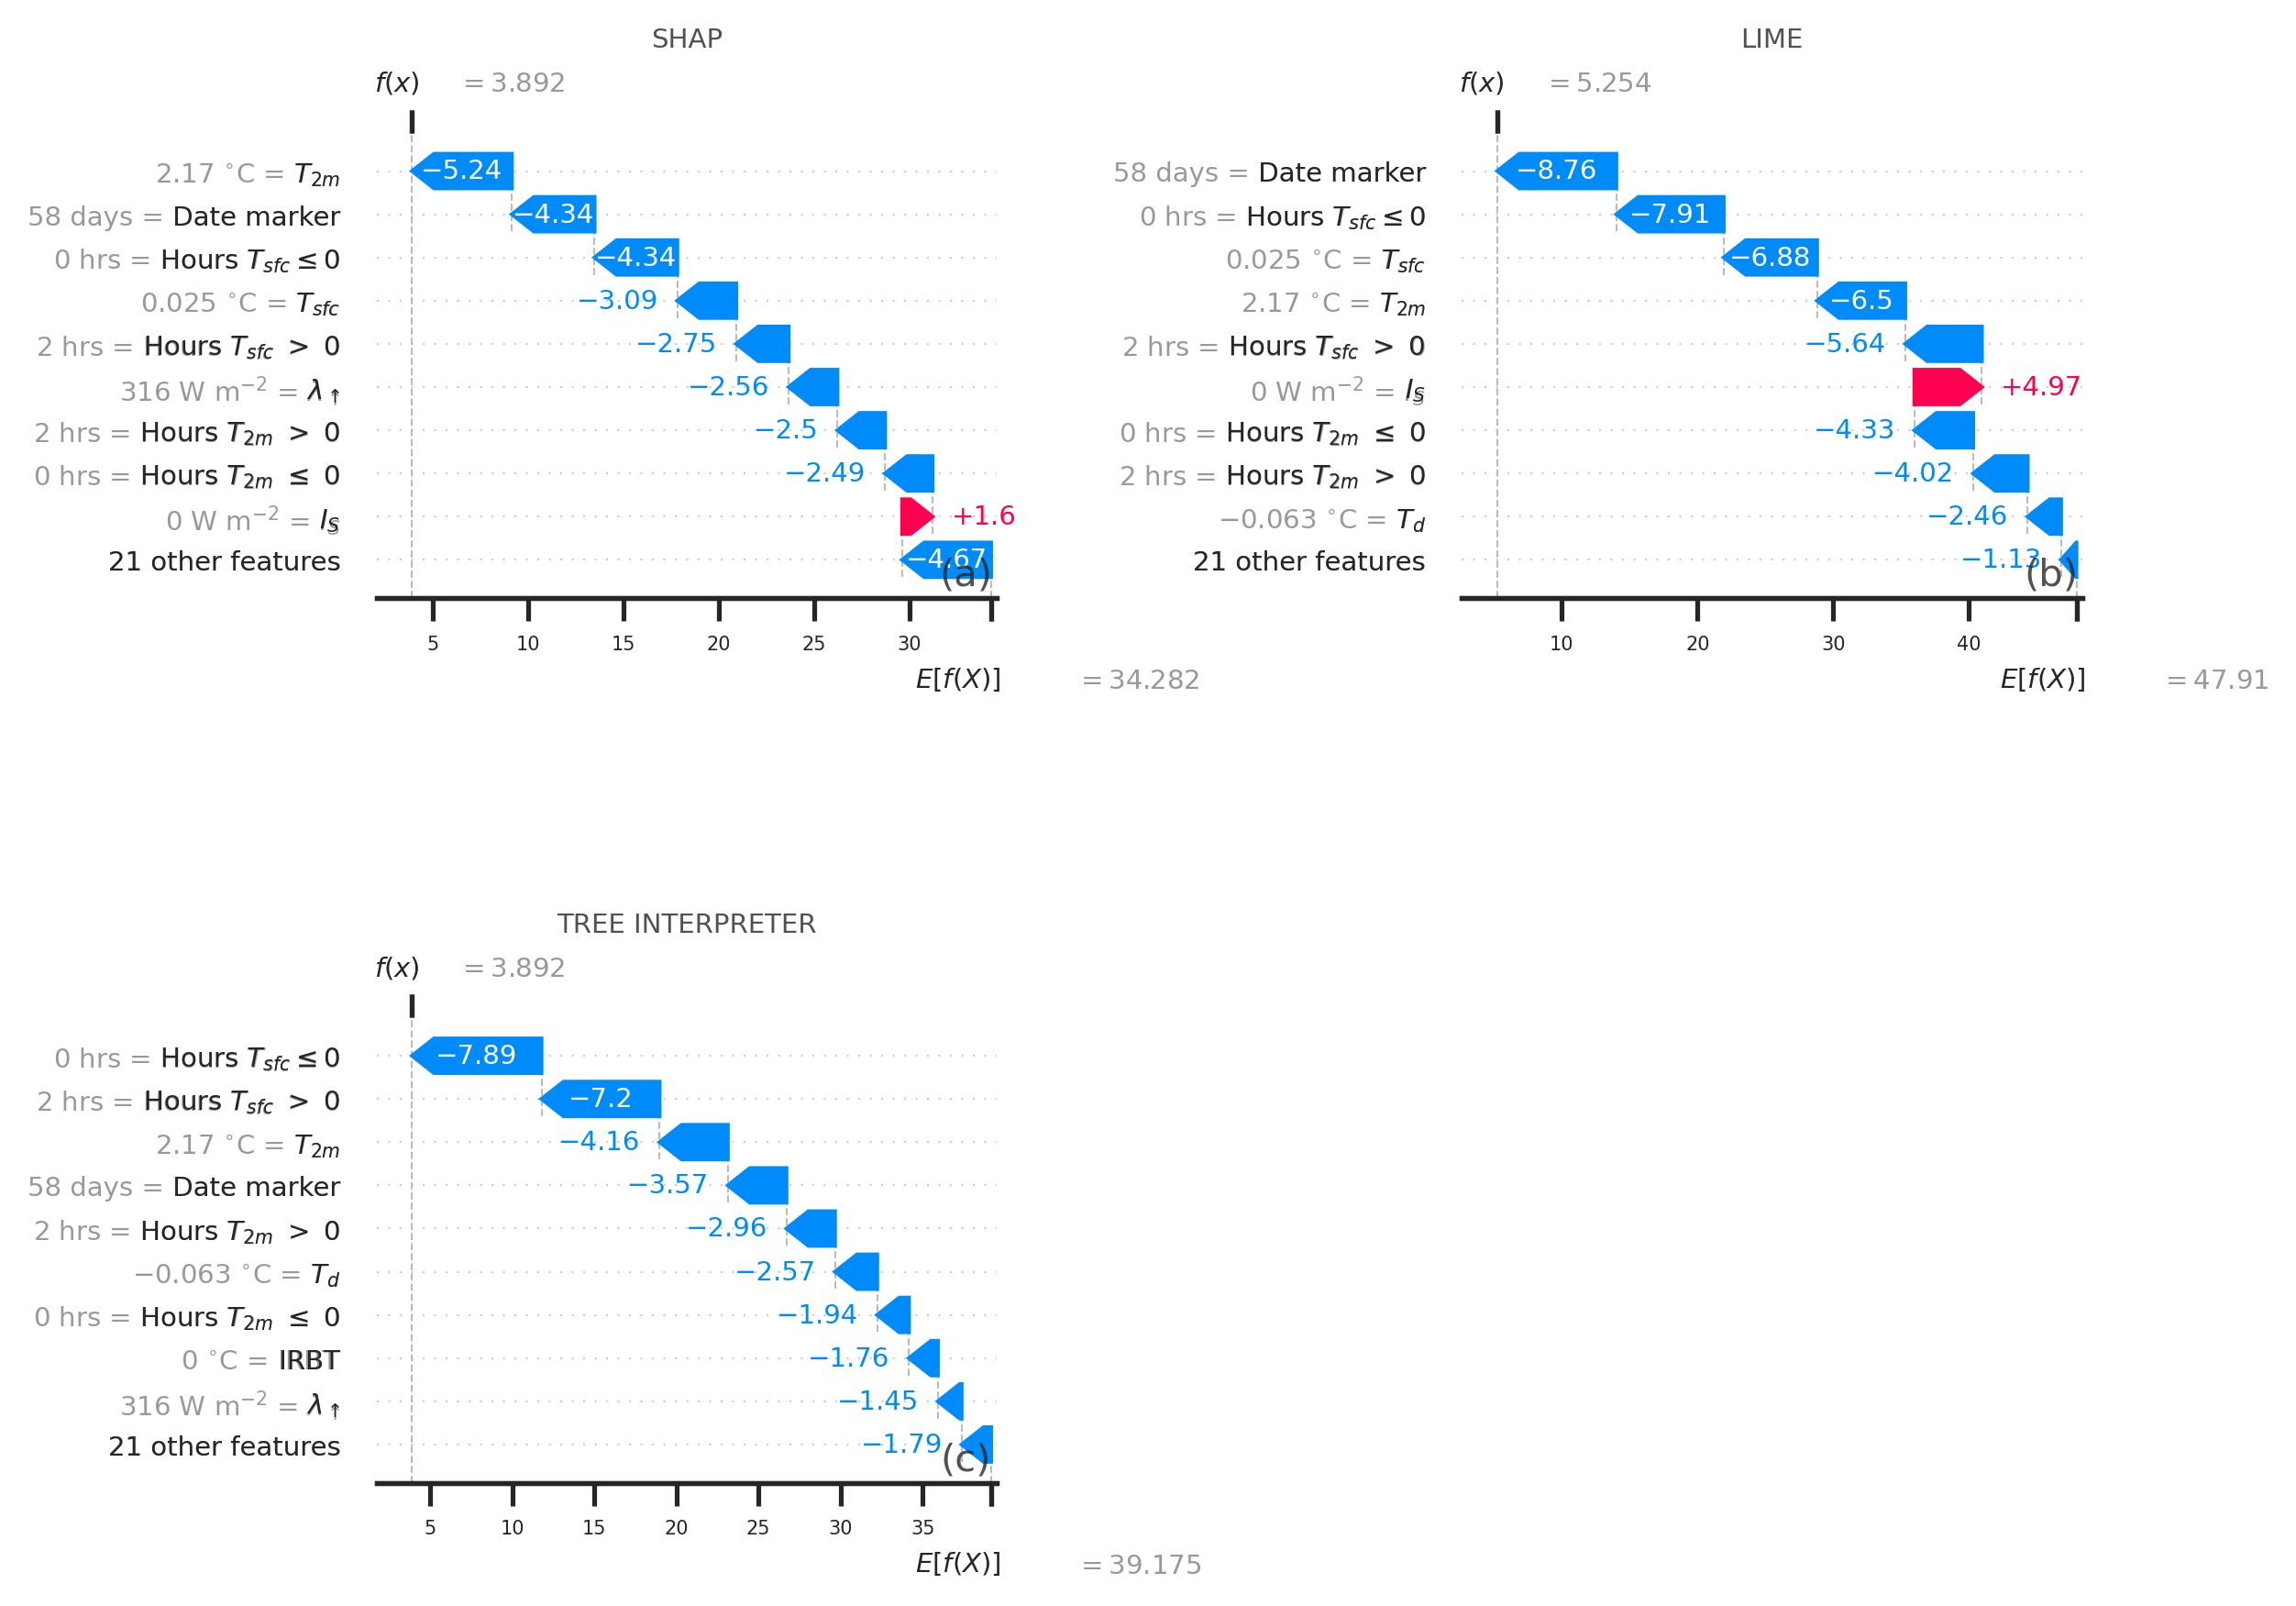

In [7]:
fig, axes = explainer.plot_contributions(
    contrib = contrib_ds, 
    display_feature_names=plotting_config.display_feature_names,
    display_units = plotting_config.display_units,
)

## Performance-based Summary of Feature Attributions

Although it can be important to assess the breakdown of a single prediction, we can also summarize feature contributions over several examples. By setting `performance_based=True`, we can summarize feature contributions for the top and worst performers. The number of examples to compute these summarized statistics is given by `n_examples`. In this case, we want to summarize the contributions over top 100 best and worst performing examples. 

__Note__: "Hits" and "Misses" are defined as a set of predictions being close to or far from the target variables (binary or regression), respectively, and "Correct Negatives (Corr Negs)" and "False Alarms" are defined as a set of predictions being close to or far from the target variable. 


In [8]:
perf_keys = ["Best Hits",
             "Worst False Alarms", 
             "Worst Misses",
            ]
explainer = skexplain.ExplainToolkit(estimators[0],X=X, y=y,)
tree_results = explainer.average_attributions(method='tree_interpreter', 
                                           performance_based=True,
                                           shap_kws=shap_kws, 
                                           lime_kws=lime_kws,
                                           n_samples=10)

To make the plots easier to digest, we can set `num_features` to restrict the plot to the features with the top attributions. Additionally, we can declare the `perf_keys` (performance keys) for plotting a subset of the performance-based results. In this case, we have excluded the correct negatives. 

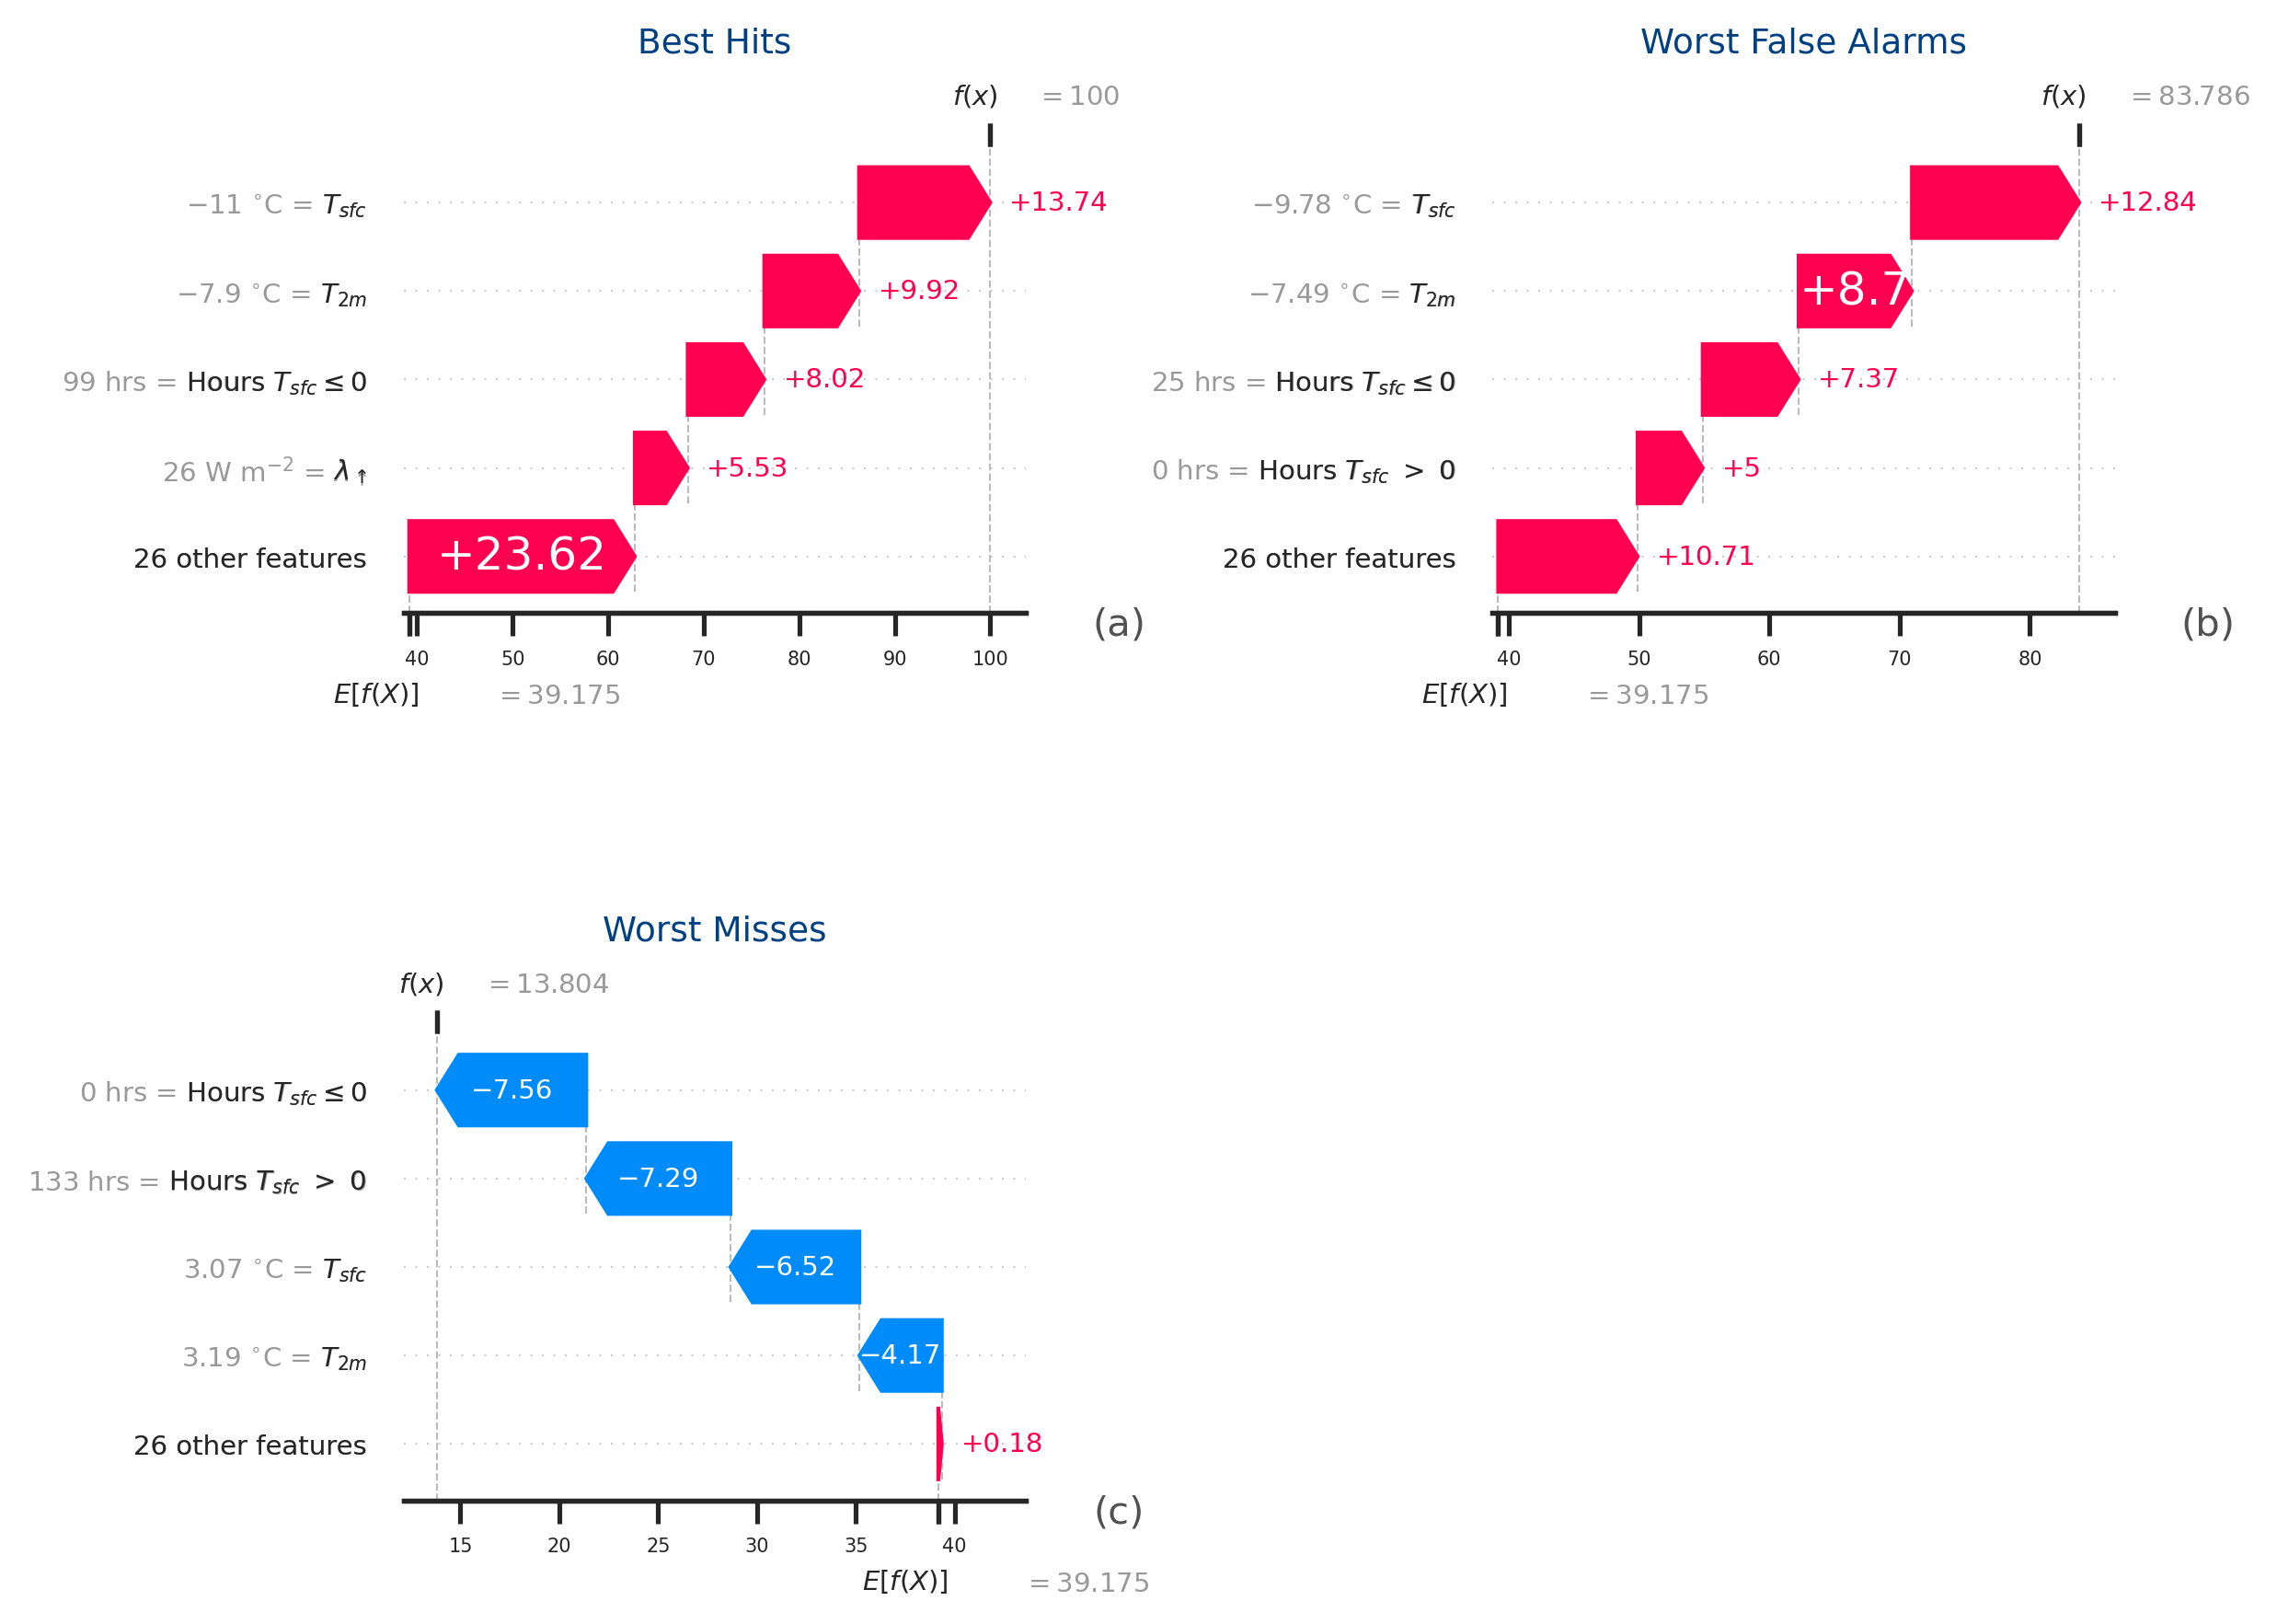

In [9]:
fig, axes = explainer.plot_contributions(
    contrib = tree_results,  
    display_feature_names=plotting_config.display_feature_names,
    display_units = plotting_config.display_units,
    perf_keys=perf_keys, 
    num_features=5
)

## Feature Contributions for Regression Problems

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [11]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
model = RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor()

In [12]:
single_example = X[[100]]
explainer = skexplain.ExplainToolkit(('Random Forest', model),
                                    X=single_example,
                                    feature_names = feature_names)

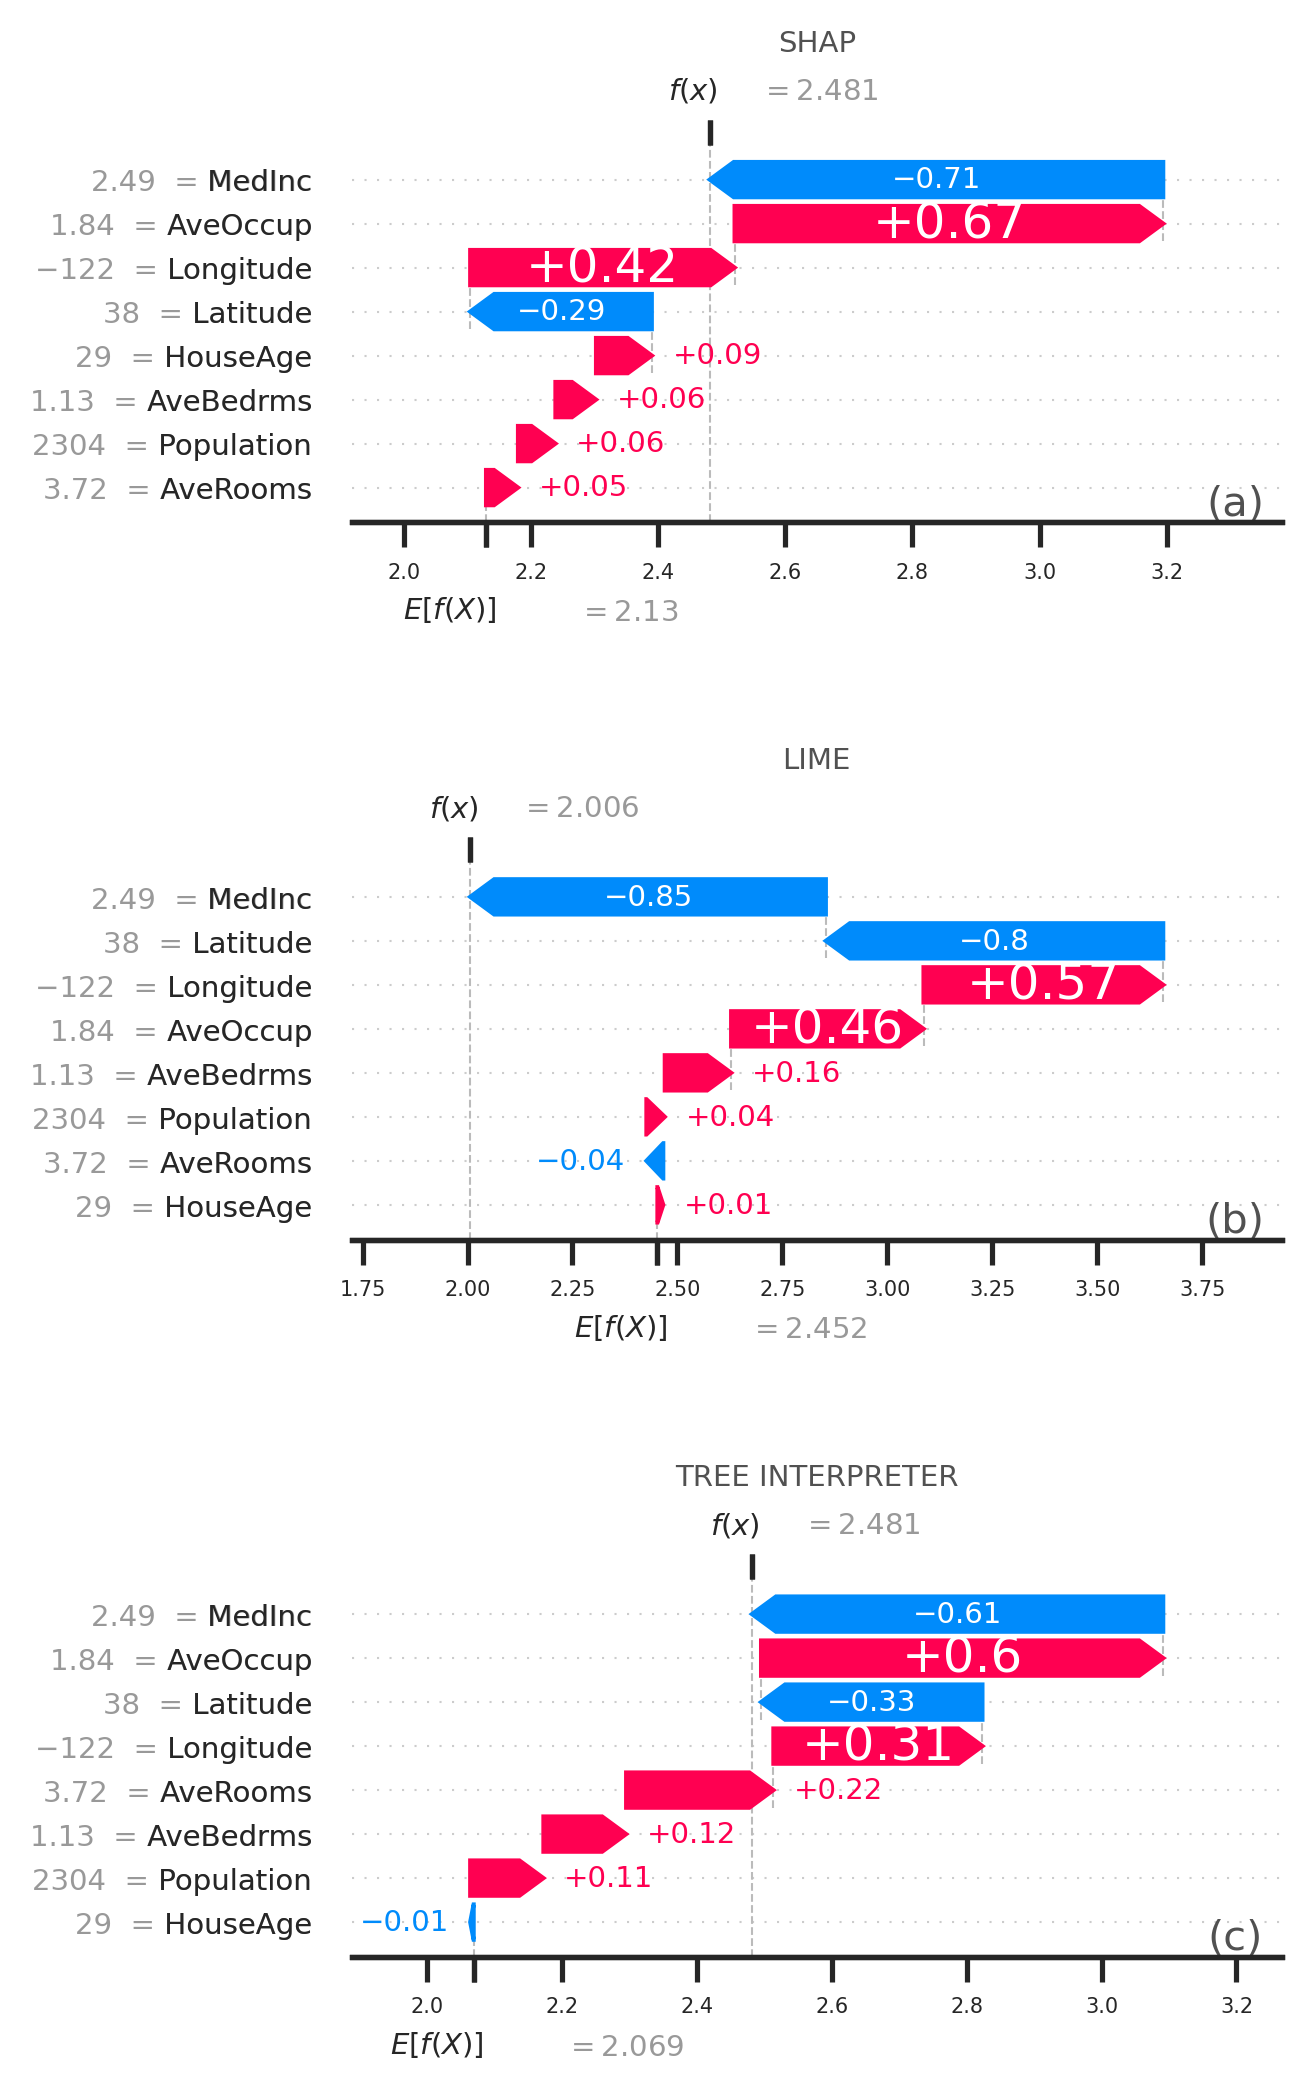

In [16]:
shap_kws={'masker' : shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 
             'algorithm' : 'auto'}

lime_kws = {'training_data' : X}

results = explainer.local_attributions(method=['shap', 'lime', 'tree_interpreter'], 
                                       shap_kws=shap_kws, lime_kws=lime_kws,)
                                        
fig = explainer.plot_contributions(results, figsize=(4,8))